# A Python Tour of Data Science: Data Acquisition & Exploration     

[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

# Exercise: problem definition

Theme of the exercise: **understand the impact of your communication on social networks**. A real life situation: the marketing team needs help in identifying which were the most engaging posts they made on social platforms to prepare their next [AdWords](https://www.google.com/adwords/) campaign.

This notebook is the second part of the exercise. Given the data we collected from Facebook an Twitter in the last exercise, we will construct an ML model and evaluate how good it is to predict the number of likes of a post / tweet given the content.

# 1 Data importation

1. Use `pandas` to import the `facebook.sqlite` and `twitter.sqlite` databases.
2. Print the 5 first rows of both tables.

The `facebook.sqlite` and `twitter.sqlite` SQLite databases can be created by running the [data acquisition and exploration exercise](01_sol_acquisition_exploration.ipynb).

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import os.path

folder = os.path.join('..', 'data', 'social_media')

fb = pd.read_sql('facebook', 'sqlite:///' + os.path.join(folder, 'facebook.sqlite'), index_col='index')
tw = pd.read_sql('twitter', 'sqlite:///' + os.path.join(folder, 'twitter.sqlite'), index_col='index')

display(fb[:5])
display(tw[:5])

,id,text,time,likes,comments
index,,,,,
0,107201356009441_1349732228423008,Découvrez les photos du tournage de notre band...,2016-10-24 09:56:21,24,0
1,107201356009441_1346592535403644,Two architecture student turn downtown Lausann...,2016-10-21 17:00:01,143,1
2,107201356009441_1346583242071240,Adding a single chemical when making biofuels ...,2016-10-21 13:20:04,42,0
3,107201356009441_1345683875494510,Une très belle lumière ce soir sur le campus!,2016-10-20 17:07:48,531,6
4,107201356009441_1345641658832065,New online programs offered by the EPFL Extens...,2016-10-20 16:26:03,80,2


,id,text,time,likes,shares
index,,,,,
0,789509789755830272,Architecture students design a car-free Lausan...,2016-10-21 16:52:56,8,7
1,789500337619083264,A vitamin could help treat Duchenne muscular d...,2016-10-21 16:15:23,1,2
2,789492707790028800,RT @epfl_exts: Thanks to @EPFL president Patri...,2016-10-21 15:45:04,0,6
3,789471927735840768,A single chemical can transform a waste produc...,2016-10-21 14:22:29,5,5
4,789470735093956608,RT @physorg_com: Turning biofuel waste into we...,2016-10-21 14:17:45,0,12


# 2 Vectorization

First step: transform the data into a format understandable by the machine. What to do with text ? A common choice is the so-called [*bag-of-word*](https://en.wikipedia.org/wiki/Bag-of-words_model) model, where we represent each word a an integer and simply count the number of appearances of a word into a document.

**Example**

Let's say we have a vocabulary represented by the following correspondance table.

| Integer | Word    |
|:-------:|---------|
|    0    | unknown |
|    1    | dog     |
|    2    | school  |
|    3    | cat     |
|    4    | house   |
|    5    | work    |
|    6    | animal  |

Then we can represent the following document
> I have a cat. Cats are my preferred animals.

by the vector $x = [6, 0, 0, 2, 0, 0, 1]^T$.

**Tasks**

1. Construct a vocabulary of the 100 most occuring words in your dataset.
2. Build a vector $x \in \mathbb{R}^{100}$ for each document (post or tweet).

Tip: the natural language modeling libraries [nltk](http://www.nltk.org/) and [gensim](https://radimrehurek.com/gensim/) are useful for advanced operations. You don't need them here.

Arise a first *data cleaning* question. We may have some text in french and other in english. What do we do ?

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

nwords = 200  # 100

def compute_bag_of_words(text, nwords):
    vectorizer = CountVectorizer(max_features=nwords)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

fb_bow, fb_vocab = compute_bag_of_words(fb.text, nwords)
#fb_p = pd.Panel({'orig': fb, 'bow': fb_bow})
display(fb_bow)
display(fb_vocab[100:110])

tw_bow, tw_vocab = compute_bag_of_words(tw.text, nwords)
display(tw_bow)

<816x200 sparse matrix of type '<class 'numpy.int64'>'
	with 12139 stored elements in Compressed Sparse Row format>

['lire',
 'ly',
 'mars',
 'martin',
 'master',
 'may',
 'monde',
 'more',
 'new',
 'nous']

<3211x200 sparse matrix of type '<class 'numpy.int64'>'
	with 25217 stored elements in Compressed Sparse Row format>

Exploration question: what are the 5 most used words ? Exploring your data while playing with it is a useful sanity check.

In [3]:
def print_most_frequent(bow, vocab, n=10):
    idx = np.argsort(bow.sum(axis=0))
    for i in range(10):
        j = idx[0, -i]
        print(vocab[j])

print_most_frequent(tw_bow, tw_vocab)
print('---')
print_most_frequent(fb_bow, fb_vocab)

hand
co
http
the
epfl
rt
https
to
of
in
---
off
the
http
de
epfl
ly
bit
of
la
and


# 3 Pre-processing

1. The independant variables $X$ are the bags of words.
2. The target $y$ is the number of likes.
3. Split in half for training and testing sets.

In [4]:
X = tw_bow
y = tw['likes'].values

n, d = X.shape
assert n == y.size

print(X.shape)
print(y.shape)

(3211, 200)
(3211,)


In [5]:
# Training and testing sets.
test_size = n // 2
print('Split: {} testing and {} training samples'.format(test_size, y.size - test_size))
perm = np.random.permutation(y.size)
X_test  = X[perm[:test_size]]
X_train = X[perm[test_size:]]
y_test  = y[perm[:test_size]]
y_train = y[perm[test_size:]]

Split: 1605 testing and 1606 training samples


# 4 Linear regression

Using `numpy`, fit and evaluate the [linear model](https://en.wikipedia.org/wiki/Linear_regression) $$\hat{w}, \hat{b} = \operatorname*{arg min}_{w,b} \| Xw + b - y \|_2^2.$$

Please define a class `LinearRegression` with two methods:
1. `fit` learn the parameters $w$ and $b$ of the model given the training examples.
2. `predict` gives the estimated number of likes of a post / tweet. That will be used to evaluate the model on the testing set.

To evaluate the classifier, create an `accuracy(y_pred, y_true)` function which computes the mean squared error $\frac1n \| \hat{y} - y \|_2^2$.

Hint: you may want to use the function `scipy.sparse.linalg.spsolve()`.

If `solve` and `spsolve` tells you that your matrix is singular, please read this [good comment](http://stats.stackexchange.com/questions/70899/what-correlation-makes-a-matrix-singular-and-what-are-implications-of-singularit). Potential solutions:
1. Is there any post / tweet without any word from the vocabulary ? I.e. a row of $X$ made only of zeroes. If yes, remove this row or enlarge the vocabulary.
2. Identify and remove redundant features, i.e. words, who are linear combinations of others.
3. What else could we do ?

In [6]:
import scipy.sparse

class LinearRegression(object):
    
    def predict(self, X):
        """Return the predicted class given the features."""
        return X.dot(self.w) + self.b
    
    def fit(self, X, y):
        """Learn the model's parameters given the training data, the closed-form way."""
        n, d = X.shape
        self.b = y.mean()
        A = X.T.dot(X)
        b = X.T.dot(y - self.b)
        #self.w = np.linalg.solve(A, b)
        self.w = scipy.sparse.linalg.spsolve(A, b)

def evaluate(y_pred, y_true):
    return np.linalg.norm(y_pred - y_true, ord=2)**2 / y_true.size

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = evaluate(y_pred, y_test)
print('mse: {:.4f}'.format(mse))

mse: 4.3624


Interpretation: what are the most important words a post / tweet should include ?

In [7]:
idx = np.argsort(abs(model.w))

for i in range(20):
    j = idx[-1-i]
    print('weight: {:5.2f}, word: {}'.format(model.w[j], tw_vocab[j]))

weight:  3.01, word: see
weight:  2.24, word: 10
weight:  2.12, word: just
weight:  2.01, word: light
weight: -1.91, word: upmicblog
weight:  1.72, word: who
weight: -1.67, word: technologisteu
weight: -1.60, word: rt
weight:  1.56, word: best
weight:  1.46, word: congratulations
weight:  1.45, word: startups
weight: -1.39, word: 2012
weight:  1.30, word: next
weight:  1.29, word: rolex
weight:  1.23, word: co
weight:  1.20, word: years
weight:  1.14, word: place
weight: -1.08, word: method
weight: -1.07, word: like
weight:  1.06, word: university


# 5 Interactivity

1. Create a slider for the number of words, i.e. the dimensionality of the samples $x$.
2. Print the accuracy for each change on the slider.

In [8]:
import ipywidgets
from IPython.display import clear_output

slider = ipywidgets.widgets.IntSlider(
    value=1,
    min=1,
    max=nwords,
    step=1,
    description='nwords',
)

def handle(change):
    """Handler for value change: fit model and print performance."""
    nwords = change['new']
    clear_output()
    print('nwords = {}'.format(nwords))
    model = LinearRegression()
    model.fit(X_train[:, :nwords], y_train)
    y_pred = model.predict(X_test[:, :nwords])
    mse = evaluate(y_pred, y_test)
    print('mse: {:.4f}'.format(mse))

slider.observe(handle, names='value')
display(slider)

slider.value = nwords  # As if someone moved the slider.

nwords = 200
mse: 4.3624


# 6 Scikit learn

1. Fit and evaluate the linear regression model using `sklearn`.
2. Evaluate the model with the mean squared error metric provided by `sklearn`.
3. Compare with your implementation.

In [9]:
from sklearn import linear_model, metrics

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
assert np.allclose(evaluate(y_pred, y_test), mse)
print('mse: {:.4f}'.format(mse))

mse: 4.3624


# 7 Deep Learning

Try a simple deep learning model !

Another modeling choice would be to use a Recurrent Neural Network (RNN) and feed it the sentence words after words.

In [10]:
import os
os.environ['KERAS_BACKEND'] = 'theano'  # tensorflow
import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(output_dim=50, input_dim=nwords, activation='relu'))
model.add(keras.layers.Dense(output_dim=20, activation='relu'))
model.add(keras.layers.Dense(output_dim=1, activation='relu'))
model.compile(loss='mse', optimizer='sgd')

model.fit(X_train.toarray(), y_train, nb_epoch=20, batch_size=100)
y_pred = model.predict(X_test.toarray(), batch_size=32)

mse = evaluate(y_test, y_pred.squeeze())
print('mse: {:.4f}'.format(mse))

Using Theano backend.


Epoch 1/20
1606/1606 [==============================] - 0s - loss: 6.7979     
Epoch 2/20
1606/1606 [==============================] - 0s - loss: 6.0675     
Epoch 3/20
1606/1606 [==============================] - 0s - loss: 5.6889     
Epoch 4/20
1606/1606 [==============================] - 0s - loss: 5.4113     
Epoch 5/20
1606/1606 [==============================] - 0s - loss: 5.2405     
Epoch 6/20
1606/1606 [==============================] - 0s - loss: 5.0628     
Epoch 7/20
1606/1606 [==============================] - 0s - loss: 4.9390     
Epoch 8/20
1606/1606 [==============================] - 0s - loss: 4.8591     
Epoch 9/20
1606/1606 [==============================] - 0s - loss: 4.8044     
Epoch 10/20
1606/1606 [==============================] - 0s - loss: 4.6465     
Epoch 11/20
1606/1606 [==============================] - 0s - loss: 4.5274     
Epoch 12/20
1606/1606 [==============================] - 0s - loss: 4.4536     
Epoch 13/20
1606/1606 [==========================

# 8 Evaluation

Use [matplotlib](http://matplotlib.org) to plot a performance visualization. E.g. the true number of likes and the real number of likes for all posts / tweets.

What do you observe ? What are your suggestions to improve the performance ?

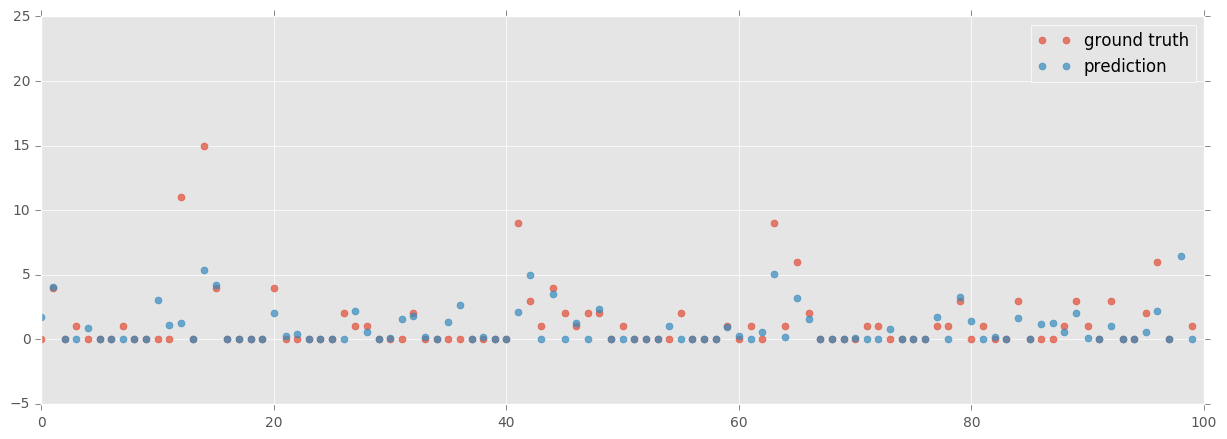

In [11]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

n = 100
plt.figure(figsize=(15, 5))
plt.plot(y_test[:n], '.', alpha=.7, markersize=10, label='ground truth')
plt.plot(y_pred[:n], '.', alpha=.7, markersize=10, label='prediction')
plt.legend()
plt.show()